# SRP-PHAT algorithm

In this notebook, we perform TDOA esimaton using the GCC-PHAT. We then use the Steered Response Power Phase Transform algorithm to perform sound source localization.

Given two signals $ x_{i}(n)$ and $ x_{j}(n)$ the GCC-PHAT is defined as:

$\displaystyle \hat{G}_{PHAT}(f) = \frac{X_{i}(f) [X_{j}(f)]^{*}}{\vert X_{i}(f) [X_{j}(f)]^{*}\vert}$, where $ X_{i}(f)$ and $ X_{j}(f)$ are the Fourier transforms of the two signals and $ [\ ]^{*}$ denotes the complex conjugate.

The TDOA for these two microphones is estimated as:

 $\displaystyle \hat{d}_{PHAT}(i,j) = {arg max \atop d} \big(\hat{R}_{PHAT}(d)\big)$, where $ \hat{R}_{PHAT}(d)$ is the inverse Fourier transform of the above function.

1. [GCC-PHAT](#gcc)
2. [SRP-PHAT](#srp)

In [229]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import math, random
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='gcc'></a>
### 1. GCC-PHAT

Create room setup

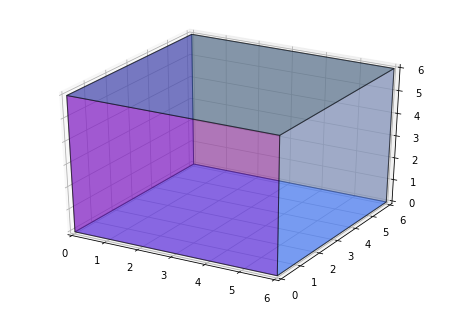

In [230]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 6, 6, 6
room_dim = np.array([room_dimX, room_dimY, room_dimZ])

#Sampling frequency
fs = 16000 # 16kHz

room = pra.ShoeBox(room_dim, fs=fs, max_order = 4, absorption=0.2)

# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6]);

Create microphone array

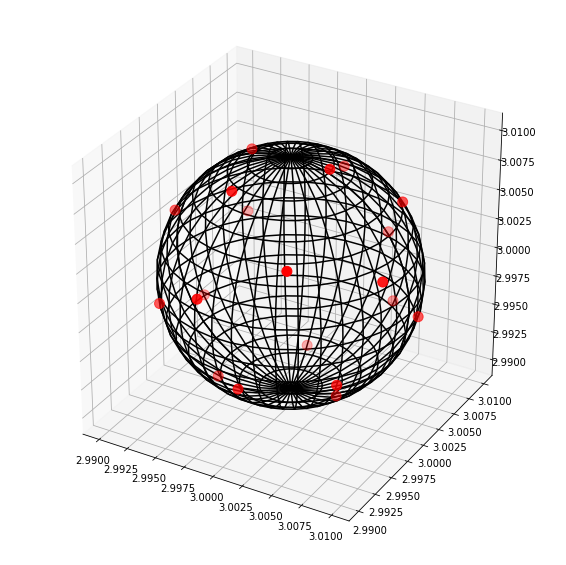

In [231]:
def sphere_micsArray(n_mics, room_dim, radius=0.01, randomize=False):
    rnd = 1.
    if randomize:
        rnd = random.random() * n_mics

    points = []
    offset = 2./n_mics
    increment = math.pi * (3. - math.sqrt(5.))

    for i in range(n_mics):
        y = ((i * offset) - 1) + (offset / 2) 
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % n_mics) * increment

        x = math.cos(phi) * r 
        z = math.sin(phi) * r 
        
        norm = np.sqrt(x**2 + y**2 + z**2)
        x /= (1/radius)*norm
        y /= (1/radius)*norm
        z /= (1/radius)*norm
        points.append([x+ room_dim[0]/2, y + room_dim[1]/2 , z + room_dim[2]/2])

    return np.array(points)

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)


x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

norm = np.sqrt(x**2 + y**2 + z**2)
x /= 100*norm
y /= 100*norm
z /= 100*norm



points = sphere_micsArray(20, room_dim)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
fig.set_size_inches(10,10,10)
ax.plot_wireframe(x + room_dim[0]/2, y + room_dim[1]/2, z + room_dim[2]/2, color='k', rstride=1, cstride=1)
ax.scatter(points[:,0], points[:,1], points[:,2], s=100, c='r', zorder=10)

In [232]:
#Microphone position

# R = np.c_[
#     [3, 3.05, 3],  # mic 1
#     [3, 2.95, 3],  # mic 2
#     ]
#distance = np.linalg.norm(R[:,0]-R[:,1])


# the fs of the microphones is the same as the room
mic_array = pra.MicrophoneArray(points.T, room.fs)

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

In [233]:
def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y/x)
    
    return r, theta, phi

def spherical_to_cartesian(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    return x, y, z

def changeOf_axes(posX, posY, posZ, room_dim):
    new_X = posX - room_dim[0]/2 
    new_Y = posY - room_dim[1]/2 
    new_Z = posZ - room_dim[2]/2 

    return new_X, new_Y, new_Z

Add source

In [234]:
fs, signal = wavfile.read("test1.wav")

posX, posY, posZ = 2, 2, 2


new_X, new_Y, new_Z = changeOf_axes(posX, posY, posZ, room_dim)
norm_pos = np.sqrt(new_X**2 + new_Y**2 + new_Z**2)

#r_gt, theta_gt, phi_gt = cartesian_to_spherical(posX/norm_pos, posY/norm_pos, posZ/norm_pos)

source_location = room_dim / 2 + spherical_to_cartesian(r=1, theta=(45*np.pi)/180, phi=(60*np.pi)/180)
#source_location = np.array([posX, posY, posZ])

room.add_source(source_location, signal=signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

rir = room.rir

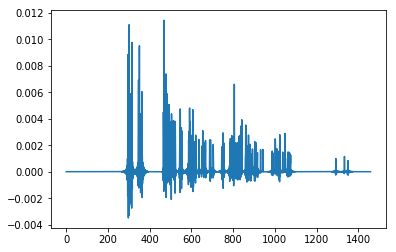

In [235]:
#plot the RIR between mic 0 and source
plt.plot(room.rir[0][0])
plt.show()

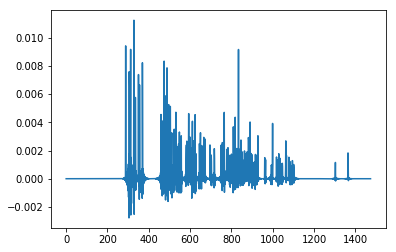

In [236]:
#plot the RIR between mic 1 and source
plt.plot(room.rir[2][0])
plt.show()

Simulate sound propagation

In [237]:
room.simulate()

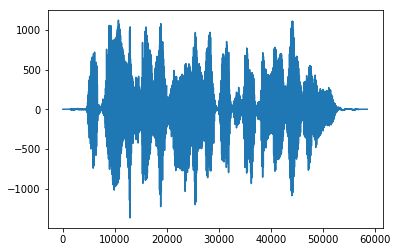

In [238]:
# plot signal at microphone 0
plt.plot(room.mic_array.signals[0,:])

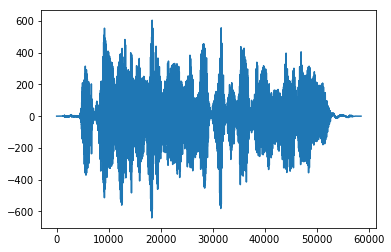

In [239]:
# plot signal at microphone 1
plt.plot(room.mic_array.signals[1,:])

In [240]:
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    from : https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [241]:
sound_speed = 343.2
max_tau = distance/sound_speed
tau, cc = gcc_phat(room.mic_array.signals[0,:], room.mic_array.signals[1,:], fs=fs, max_tau=max_tau)

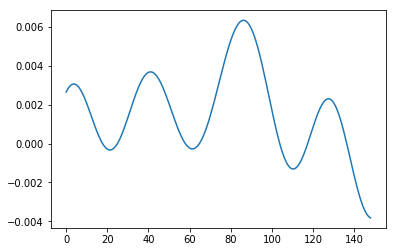

In [242]:
plt.plot(cc)

In [243]:
print("TDOA between the 2 microphone is: {tdoa}s".format(tdoa=abs(tau)))

TDOA between the 2 microphone is: 4.6875e-05s


<a id='srp'></a>
### 2. SRP PHAT

In [244]:
nfft = 256  # FFT size
freq_range = [300, 3500]
srp = pra.doa.srp.SRP(R, fs, nfft, dim=3, mode='near')

The DOA algorithms require an STFT input, which we will compute for overlapping frames for our 1 second duration signal.

In [245]:
X = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in room.mic_array.signals])

In [247]:
srp.locate_sources(X,freq_range=freq_range, num_src=1)

In [248]:
phi_recon = srp.azimuth_recon[0]
theta_recon = srp.colatitude_recon[0]

In [249]:
phi_recon

-1.9160679465731603

In [250]:
theta_recon

3.057680988304991

In [196]:
x_recon, y_recon, z_recon = spherical_to_cartesian(norm_pos, theta_recon, phi_recon)

In [197]:
x_recon

0.2466604348491839

In [198]:
y_recon

-0.08954413468512891

In [199]:
z_recon

1.7120573815802738

In [200]:
def micAxis_to_orgAxis(x_mic, y_mic, z_mic, room_dim):
    x_src = room_dim[0]/2 + x_mic
    y_src = room_dim[1]/2 + y_mic
    z_src = room_dim[2]/2 + z_mic
    
    return x_src, y_src, z_src

In [201]:
x_src, y_src, z_src = micAxis_to_orgAxis(x_recon, y_recon, z_recon, room_dim)

In [202]:
x_src

3.246660434849184

In [203]:
y_src

2.910455865314871

In [204]:
z_src

4.712057381580274